In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
%config Completer.use_jedi = False

In [3]:
from replay.session_handler import State

spark = State().session
spark

In [4]:
from rs_datasets import MovieLens

data = MovieLens("1m")
data.info()

ratings


,user_id,item_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968



users


,user_id,gender,age,occupation,zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117



items


,item_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [5]:
from replay.data_preparator import DataPreparator

log = DataPreparator().transform(
    data=data.ratings,
    columns_names={
        "user_id": "user_id",
        "item_id": "item_id",
        "relevance": "rating",
        "timestamp": "timestamp"
    }
)

In [6]:
from replay.splitters import UserSplitter

splitter = UserSplitter(
    drop_cold_items=True,
    drop_cold_users=True,
    item_test_size=5,
    user_test_size=2000,
    seed=1234,
    shuffle=True
)
train, test = splitter.split(log)
(
    train.count(), 
    test.count()
)

(990209, 9998)

In [7]:
train.select('user_id').distinct().count(), train.select('item_id').distinct().count(), 

(6040, 3704)

In [8]:
test.select('user_id').distinct().count(), test.select('item_id').distinct().count(), 

(2000, 2083)

In [9]:
K_quality = [1, 5]
SEED=123

# ADMM SLIM с дефолтными параметрами

In [10]:
from replay.models import ADMMSLIM

admm_slim = ADMMSLIM(seed=SEED)

TypeError: __init__() missing 2 required positional arguments: 'lambda_1' and 'lambda_2'

Проблема: нет дефолтных параметров

In [11]:
from replay.metrics import HitRate, NDCG, MAP, Coverage
from replay.experiment import Experiment

metrics = Experiment(test, {NDCG(): K_quality,
                            MAP() : K_quality,
                            HitRate(): K_quality,
                            Coverage(train): K_quality})

# ADMM SLIM optimize

In [12]:
admm_slim = ADMMSLIM(seed=SEED, lambda_1=0.1, lambda_2=0.1)

In [14]:
%%time
best_p = admm_slim.optimize(train, 
                       test,
                       budget=50,
                       experiment=metrics
                      )

[I 2021-02-05 14:00:51,798] A new study created in memory with name: no-name-c87b68a1-589a-4610-ac9f-3a68ced06467
05-Feb-21 14:00:51, replay, DEBUG: -- Второй фит модели в оптимизации
DEBUG:replay:-- Второй фит модели в оптимизации
05-Feb-21 14:00:51, replay, DEBUG: Начало обучения ADMMSLIM
DEBUG:replay:Начало обучения ADMMSLIM
05-Feb-21 14:00:51, replay, DEBUG: Предварительная стадия обучения (pre-fit)
DEBUG:replay:Предварительная стадия обучения (pre-fit)
05-Feb-21 14:00:53, replay, DEBUG: Основная стадия обучения (fit)
DEBUG:replay:Основная стадия обучения (fit)
05-Feb-21 14:00:55, replay, DEBUG: Построение модели ADMM SLIM
DEBUG:replay:Построение модели ADMM SLIM
05-Feb-21 14:00:56, replay, DEBUG: Матрица Грама
DEBUG:replay:Матрица Грама
05-Feb-21 14:00:58, replay, DEBUG: Поиск обратной матрицы
DEBUG:replay:Поиск обратной матрицы
05-Feb-21 14:01:01, replay, DEBUG: Основной  расчет
DEBUG:replay:Основной  расчет
05-Feb-21 14:01:10, replay, INFO: Итерация: 1. primal gap: 2.1358e+04; d

CPU times: user 4h 21min 26s, sys: 2h 59min 4s, total: 7h 20min 30s
Wall time: 40min 59s


In [15]:
metrics.results.to_csv('admm_slim_opt_res_5000.csv')

In [16]:
best_p

{'lambda_1': 2.8204011407986096, 'lambda_2': 991.2762048073065}

In [21]:
import pandas as pd
pd.options.display.float_format = '{:,.8f}'.format

In [22]:
metrics.results.sort_values('NDCG@5', ascending=False)

,Coverage@1,Coverage@5,HitRate@1,HitRate@5,MAP@1,MAP@5,NDCG@1,NDCG@5,_lambda_1_param,_lambda_2_param,_time_param
ADMMSLIM_45,0.12500000,0.26862851,0.20100000,0.51950000,0.20100000,0.08572500,0.20100000,0.15203633,2.82040114,991.27620481,87.47948718
ADMMSLIM_32,0.12257019,0.25917927,0.20350000,0.51050000,0.20350000,0.08529667,0.20350000,0.15060701,0.00049381,969.32457253,28.54001880
ADMMSLIM_35,0.12688985,0.27753780,0.19650000,0.51100000,0.19650000,0.08461667,0.19650000,0.14989632,0.00116483,950.29625809,27.65123510
ADMMSLIM_44,0.12985961,0.27267819,0.19450000,0.51200000,0.19450000,0.08393833,0.19450000,0.14912167,2.02866547,774.74671585,86.10415053
ADMMSLIM_42,0.13012959,0.28293737,0.19550000,0.50850000,0.19550000,0.08390500,0.19550000,0.14881053,0.05658923,884.71628874,44.57619572
ADMMSLIM_31,0.12176026,0.25026998,0.19650000,0.50800000,0.19650000,0.08386833,0.19650000,0.14864298,0.00028349,881.16465038,31.41472602
ADMMSLIM_24,0.12419006,0.26106911,0.18950000,0.50350000,0.18950000,0.08264000,0.18950000,0.14670046,0.00011768,742.14861242,25.85079241
ADMMSLIM_14,0.12931965,0.28050756,0.19100000,0.50200000,0.19100000,0.08270167,0.19100000,0.14661665,0.00785175,770.10149136,32.06176472
ADMMSLIM_25,0.13363931,0.28347732,0.19200000,0.49900000,0.19200000,0.08246500,0.19200000,0.14615551,0.29826188,745.83681175,84.61850905
ADMMSLIM_11,0.12203024,0.25269978,0.19000000,0.49550000,0.19000000,0.08219333,0.19000000,0.14553640,0.00005175,724.14399899,26.90555525


# Визуализация метрик в зависимости от одного из параметров

In [23]:
to_plot = metrics.results[['NDCG@5', 'Coverage@5', '_lambda_1_param', '_lambda_2_param', '_time_param']]

In [24]:
to_plot.sort_values('NDCG@5', ascending=False)

,NDCG@5,Coverage@5,_lambda_1_param,_lambda_2_param,_time_param
ADMMSLIM_45,0.15203633,0.26862851,2.82040114,991.27620481,87.47948718
ADMMSLIM_32,0.15060701,0.25917927,0.00049381,969.32457253,28.54001880
ADMMSLIM_35,0.14989632,0.27753780,0.00116483,950.29625809,27.65123510
ADMMSLIM_44,0.14912167,0.27267819,2.02866547,774.74671585,86.10415053
ADMMSLIM_42,0.14881053,0.28293737,0.05658923,884.71628874,44.57619572
ADMMSLIM_31,0.14864298,0.25026998,0.00028349,881.16465038,31.41472602
ADMMSLIM_24,0.14670046,0.26106911,0.00011768,742.14861242,25.85079241
ADMMSLIM_14,0.14661665,0.28050756,0.00785175,770.10149136,32.06176472
ADMMSLIM_25,0.14615551,0.28347732,0.29826188,745.83681175,84.61850905
ADMMSLIM_11,0.14553640,0.25269978,0.00005175,724.14399899,26.90555525


In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

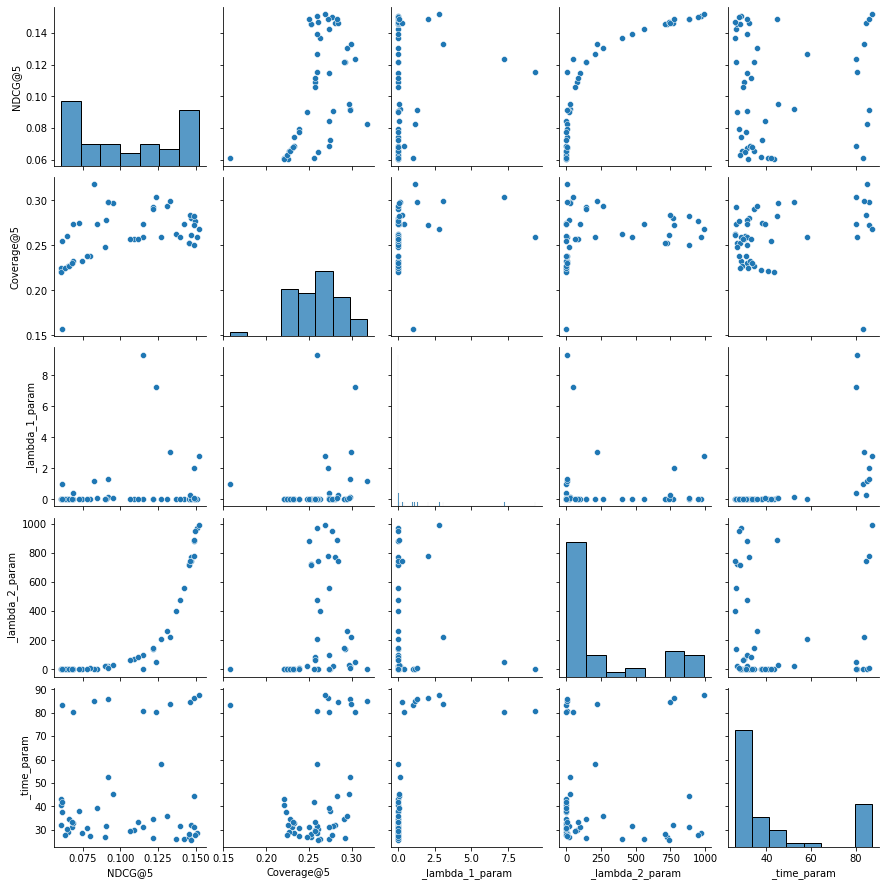

In [42]:
sns.pairplot(to_plot)

Text(0.5, 1.0, 'NDCG')

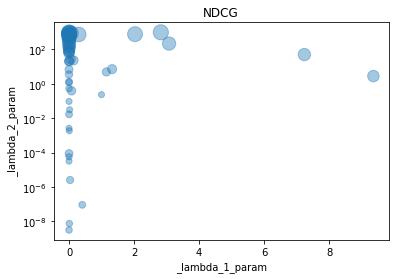

In [49]:
size = (to_plot['NDCG@5']**2)*10000

plt.scatter(to_plot['_lambda_1_param'], to_plot['_lambda_2_param'], s=size, 
            alpha=0.4)
plt.yscale('log')
plt.xlabel('_lambda_1_param')
plt.ylabel('_lambda_2_param')
plt.title('NDCG')


# Params set as default

In [57]:
# params = ((10, 1000), (10, 5000), (5, 1000), (5, 5000), (30, 1000), (30, 5000))
params = ((10, 2000), (10, 3000), (5, 3000), (5, 2000), (30, 2000), (30, 3000))
for lambda_1, lambda_2 in params:
    admm_slim = ADMMSLIM(seed=SEED, lambda_1=lambda_1, lambda_2=lambda_2)
    admm_slim.fit(log=train)
    recs = admm_slim.predict(
        k=10,
        users=test.select('user_id').distinct(),
        items=test.select('item_id').distinct(),
        log=train,
        filter_seen_items=True
)
    metrics.add_result('ADMMSLIM_{}_{}'.format(lambda_1, lambda_2), recs, add_params={'lambda_1': lambda_1, 'lambda_2': lambda_2})
    

05-Feb-21 15:29:50, replay, DEBUG: Начало обучения ADMMSLIM
DEBUG:replay:Начало обучения ADMMSLIM
05-Feb-21 15:29:50, replay, DEBUG: Предварительная стадия обучения (pre-fit)
DEBUG:replay:Предварительная стадия обучения (pre-fit)
05-Feb-21 15:29:50, replay, DEBUG: Основная стадия обучения (fit)
DEBUG:replay:Основная стадия обучения (fit)
05-Feb-21 15:29:52, replay, DEBUG: Построение модели ADMM SLIM
DEBUG:replay:Построение модели ADMM SLIM
05-Feb-21 15:29:52, replay, DEBUG: Матрица Грама
DEBUG:replay:Матрица Грама
05-Feb-21 15:29:54, replay, DEBUG: Поиск обратной матрицы
DEBUG:replay:Поиск обратной матрицы
05-Feb-21 15:29:56, replay, DEBUG: Основной  расчет
DEBUG:replay:Основной  расчет
05-Feb-21 15:29:58, replay, INFO: Итерация: 1. primal gap: 13.848; dual gap:  3.5999e+06; rho: 1000.0
INFO:replay:Итерация: 1. primal gap: 13.848; dual gap:  3.5999e+06; rho: 1000.0
05-Feb-21 15:29:59, replay, INFO: Итерация: 2. primal gap: 3.9195; dual gap:  4.5768e+05; rho: 500.0
INFO:replay:Итерация:

In [62]:
metrics.results.sort_values('NDCG@5', ascending=False)[:20]

,Coverage@1,Coverage@5,HitRate@1,HitRate@5,MAP@1,MAP@5,NDCG@1,NDCG@5,_lambda_1_param,_lambda_2_param,_time_param
ADMMSLIM_5_5000,0.08531317,0.17791577,0.24800000,0.56900000,0.24800000,0.10065500,0.24800000,0.17441458,5.00000000,"5,000.00000000",nan
ADMMSLIM_30_5000,0.08072354,0.16792657,0.24350000,0.57200000,0.24350000,0.10002333,0.24350000,0.17401256,30.00000000,"5,000.00000000",nan
ADMMSLIM_10_5000,0.08477322,0.17764579,0.24600000,0.56650000,0.24600000,0.10021667,0.24600000,0.17375618,10.00000000,"5,000.00000000",nan
ADMMSLIM_30_3000,0.09044276,0.18979482,0.24550000,0.56600000,0.24550000,0.09982000,0.24550000,0.17338790,30.00000000,"3,000.00000000",nan
ADMMSLIM_30_2000,0.09719222,0.19438445,0.23750000,0.56600000,0.23750000,0.09871167,0.23750000,0.17202899,30.00000000,"2,000.00000000",nan
ADMMSLIM_10_3000,0.09557235,0.20032397,0.23850000,0.56200000,0.23850000,0.09880167,0.23850000,0.17173036,10.00000000,"3,000.00000000",nan
ADMMSLIM_5_3000,0.09665227,0.19978402,0.23700000,0.56050000,0.23700000,0.09862500,0.23700000,0.17144614,5.00000000,"3,000.00000000",nan
ADMMSLIM_10_2000,0.10097192,0.21247300,0.23500000,0.55500000,0.23500000,0.09741833,0.23500000,0.16962787,10.00000000,"2,000.00000000",nan
ADMMSLIM_5_2000,0.10259179,0.21706263,0.23000000,0.55950000,0.23000000,0.09665000,0.23000000,0.16887811,5.00000000,"2,000.00000000",nan
ADMMSLIM_30_1000,0.11069114,0.21544276,0.23150000,0.55200000,0.23150000,0.09615667,0.23150000,0.16773838,30.00000000,"1,000.00000000",nan


In [59]:
to_plot = metrics.results[['NDCG@5', 'Coverage@5', '_lambda_1_param', '_lambda_2_param', '_time_param']]

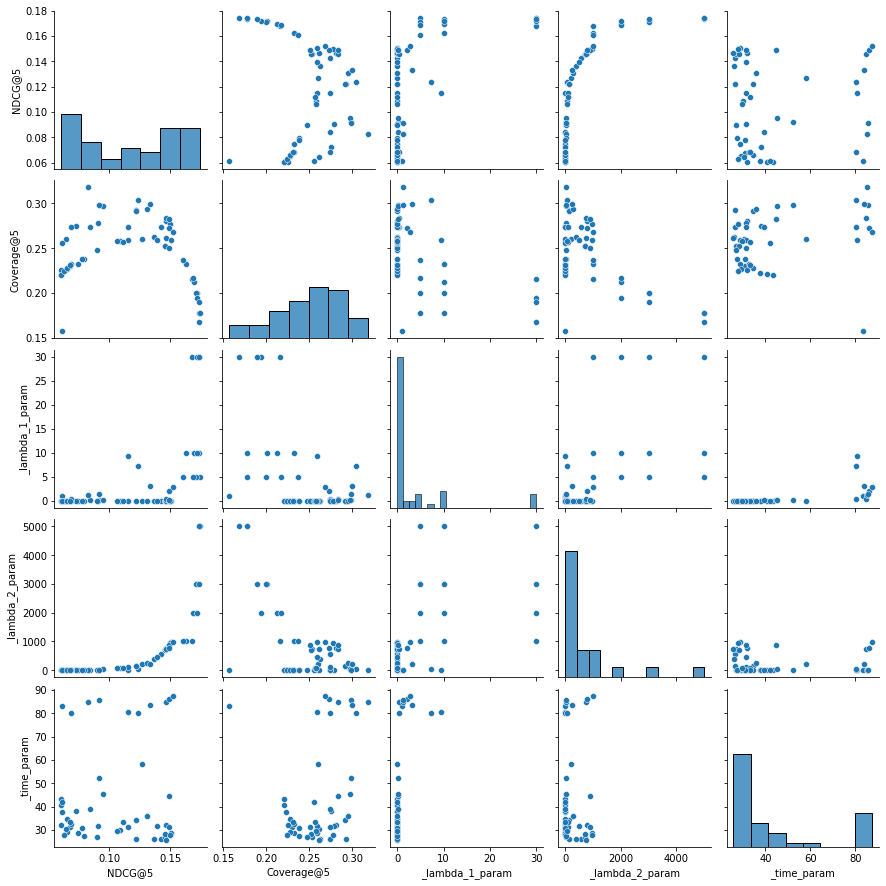

In [60]:
sns.pairplot(to_plot)

Text(0.5, 1.0, 'NDCG')

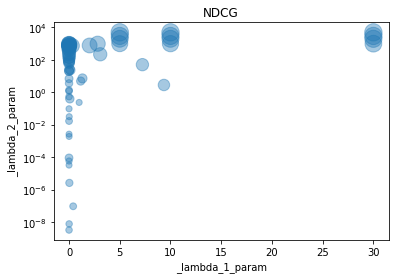

In [61]:
size = (to_plot['NDCG@5']**2)*10000

plt.scatter(to_plot['_lambda_1_param'], to_plot['_lambda_2_param'], s=size, 
            alpha=0.4)
plt.yscale('log')
plt.xlabel('_lambda_1_param')
plt.ylabel('_lambda_2_param')
plt.title('NDCG')
